# <font size=8 color=steelblue >**Phase 3: RetailSmart Advanced Analytics: Unleashing the Power of Data!**
------------------
-----------------

# <font size=5 color=lightseagreen >Business Context
---

RetailSmart is an omni-channel e-commerce company that has already built strong capabilities in data cleaning, exploratory analysis, and churn prediction.
While the predictive model (from Phase 2) helps the company identify which customers are likely to churn, senior management now wants to deepen analytical intelligence in three critical areas:  

- **Customer Segmentation** — to personalize campaigns and retention offers
- **Demand Forecasting** — to plan production, procurement, and logistics
- **Cross-Sell Recommendations** — to increase average order value through bundled sales

The goal of this phase is to use unsupervised learning, time-series analysis, and association rule mining to discover patterns and trends that cannot be easily captured through supervised modeling.

<font color=skyblue size=6>1. Import Libraries and Load Data

----------------

In [2]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.arima.model import ARIMA
from mlxtend.frequent_patterns import apriori, association_rules
import warnings
warnings.filterwarnings('ignore')

# Scaler for consistency
scaler = StandardScaler()
sns.set(style="darkgrid")

print("Libraries imported!")

Libraries imported!


In [3]:
# Load data (from Phase 2)
agg_data = pd.read_csv('/content/model_input.csv')
sales = pd.read_csv('/content/sales_cleaned.csv')

print("Data loaded!")

Data loaded!


In [4]:
# Quick peek at shapes to confirm we're good
agg_data.shape, sales.shape

((48719, 16), (26412, 14))

In [5]:
agg_data.head()

,customer_id,total_spent,total_orders,price,freight_value,payment_value,days_since_last_order,churn_flag,spend,conversions,response_rate,category_english,payment_type,channel,state,city
0,00012a2ce6f8dcda20d059ce98491703,114.74,1.0,89.80,24.94,114.74,290.0,1,0.0,0.0,0.0,Electrnics,credit_card,Unknown,SP,Osasco
1,000161a058600d5901f007fab4c27140,67.41,1.0,54.90,12.51,67.41,411.0,1,0.0,0.0,0.0,health_beauty,credit_card,Unknown,MG,Itapecerica
2,0001fd6190edaaf884bcaf3d49edf079,195.42,1.0,179.99,15.43,195.42,549.0,1,0.0,0.0,0.0,baby,credit_card,Unknown,ES,Nova Venecia
3,0002414f95344307404f0ace7a26f1d5,179.35,1.0,149.90,29.45,179.35,380.0,1,0.0,0.0,0.0,cool_stuff,boleto,Unknown,MG,Mendonca
4,000379cdec625522490c315e70c7a9fb,107.01,1.0,93.00,14.01,107.01,151.0,1,0.0,0.0,0.0,bed_bath_table,boleto,Unknown,SP,Sao Paulo


In [6]:
sales.head()

,order_id,customer_id,product_id,category_english,price,freight_value,payment_type,payment_value,order_purchase_timestamp,order_delivered_customer_date,total_price,year,month,weekday
0,00010242fe8c5a6d1ba2dd792cb16214,3ce436f183e68e07877b285a838db11a,4244733e06e7ecb4970a6e2683c13e61,cool_stuff,58.90,13.29,credit_card,72.19,2017-09-13 08:59:02,2017-09-20 23:43:48,72.19,2017.0,9.0,2.0
1,00018f77f2f0320c557190d7a144bdd3,f6dd3ec061db4e3987629fe6b26e5cce,e5f2d52b802189ee658865ca93d83a8f,pet_shop,239.90,19.93,credit_card,259.83,2017-04-26 10:53:06,2017-05-12 16:04:24,259.83,2017.0,4.0,2.0
2,000229ec398224ef6ca0657da4fc703e,6489ae5e4333f3693df5ad4372dab6d3,c777355d18b72b67abbeef9df44fd0fd,furniture_decor,199.00,17.87,credit_card,216.87,2018-01-14 14:33:31,2018-01-22 13:19:16,216.87,2018.0,1.0,6.0
3,00024acbcdf0a6daa1e931b038114c75,d4eb9395c8c0431ee92fce09860c5a06,7634da152a4610f1595efa32f14722fc,perfumery,12.99,12.79,credit_card,25.78,2018-08-08 10:00:35,2018-08-14 13:32:39,25.78,2018.0,8.0,2.0
4,00042b26cf59d7ce69dfabb4e55b4fd9,58dbd0b2d70206bf40e62cd34e84d795,ac6c3623068f30de03045865e4e10089,garden_tools,199.90,18.14,credit_card,218.04,2017-02-04 13:57:51,2017-03-01 16:42:31,218.04,2017.0,2.0,5.0


## <font size=6 color=skyblue >2. Customer Segmentation (Unsupervised: K-Means Clustering)

---

**customer segmentation** is all about unsupervised learning. We're using K-Means clustering on RFM-like features (Recency, Frequency, Monetary) plus marketing stuff like response rate. Goal: Find groups like "High-Value Loyalists" or "At-Risk Shoppers." We'll visualize with PCA and save a summary.

<font size=6> Key Features:

- **Recency**: Days since last order (from customers).
- **Frequency**: Total orders.
- **Monetary**: Total spent.
- **Avg Spend**: Total spent / orders.
- **Response Rate**: From marketing (merged by customer_id).

**Goal**: Group customers into segments (e.g., VIPs, at-risk) for personalized marketing.

> <font color=orange>Why? Supervised models predict churn, but clustering finds natural groups (e.g., "loyal spenders").

**Method**: K-Means clustering on key features.

**Sequence**: Prep data → Choose clusters → Fit model → Visualize → Interpret.

In [7]:
# Prep data – Select features for segmentation (R, F, M vibes)
segment_features = agg_data[['total_spent', 'total_orders', 'days_since_last_order']]  # RFM
segment_scaled = scaler.fit_transform(segment_features)  # Scale for fair clustering

In [8]:
# Choose number of clusters (elbow method for optimal k)
inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(segment_scaled)
    inertia.append(kmeans.inertia_)

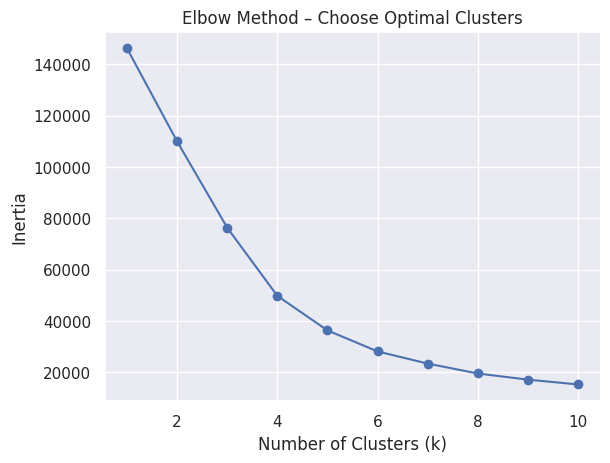

In [9]:
plt.plot(range(1, 11), inertia, marker='o')
plt.title('Elbow Method – Choose Optimal Clusters')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.show()

The elbow bend in graph clearly appears at k = 4. That’s the point where inertia drops sharply up to k=4, and then the rate of decrease flattens out — classic elbow shape. So, 4 clusters is your optimal choice for k-means.

In [10]:
# Fit K-Means with chosen k
k = 4  # Adjust based on elbow (4 for VIP, Regular, At-Risk, New)
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
clusters = kmeans.fit_predict(segment_scaled)
agg_data['segment'] = clusters

In [11]:
# Evaluate and visualize
sil_score = silhouette_score(segment_scaled, clusters)
print(f"Silhouette Score: {sil_score:.2f} (0.5+ is good clustering)")

Silhouette Score: 0.54 (0.5+ is good clustering)


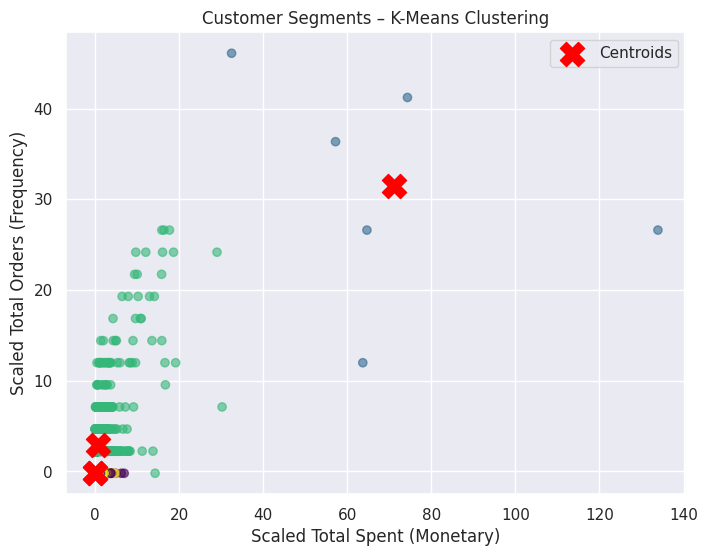

In [12]:
# Scatter plot of segments
plt.figure(figsize=(8, 6))
plt.scatter(segment_scaled[:, 0], segment_scaled[:, 1], c=clusters, cmap='viridis', alpha=0.6)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=300, c='red', marker='X', label='Centroids')
plt.title('Customer Segments – K-Means Clustering')
plt.xlabel('Scaled Total Spent (Monetary)')
plt.ylabel('Scaled Total Orders (Frequency)')
plt.legend()
plt.show()

In [14]:
# Step 5: Interpret segments
print("Segment Counts:", agg_data['segment'].value_counts())
print("\nSegment Profiles:")
for i in range(k):
    segment = agg_data[agg_data['segment'] == i]
    print(f"Segment {i}: Avg Spent={segment['total_spent'].mean():.2f}, Avg Orders={segment['total_orders'].mean():.2f}, Avg Recency={segment['days_since_last_order'].mean():.2f}")
# Insights: Segment 0 (high spent/orders) = VIPs; Segment 3 (low) = At-Risk. Target with tailored offers.

Segment Counts: segment
3    28048
0    17568
2     3097
1        6
Name: count, dtype: int64

Segment Profiles:
Segment 0: Avg Spent=159.53, Avg Orders=1.00, Avg Recency=397.25
Segment 1: Avg Spent=67273.81, Avg Orders=14.00, Avg Recency=309.00
Segment 2: Avg Spent=804.31, Avg Orders=2.26, Avg Recency=250.68
Segment 3: Avg Spent=155.43, Avg Orders=1.00, Avg Recency=142.58


<font size=6 color=skyblue >3. Demand Forecasting (Time Series Analysis)

---

**Goal**: Predict future sales/demand for planning logistics.
> <font color=orange>Why? Churn is per-customer; forecasting is for overall trends (e.g., "Sales will rise in Q4").

**Method**: ARIMA model on monthly sales.

**Sequence**: Prep time-series → Fit model → Forecast → Visualize → Interpret.


In [16]:
# Prep time-series – Aggregate sales by month
sales['order_purchase_timestamp'] = pd.to_datetime(sales['order_purchase_timestamp'])
sales_ts = sales.groupby(sales['order_purchase_timestamp'].dt.to_period('M'))['total_price'].sum()
sales_ts.index = sales_ts.index.to_timestamp()  # Convert to datetime index
print("Monthly Sales Data:\n")
sales_ts.head()

Monthly Sales Data:



,total_price
order_purchase_timestamp,
2016-09-01,136.230
2016-10-01,10592.810
2017-01-01,28617.105
2017-02-01,52016.710
2017-03-01,81742.775


In [17]:
# Fit ARIMA model (p,d,q – tune for your data; p=5, d=1, q=0 is starter)
model_arima = ARIMA(sales_ts, order=(5, 1, 0))  # p=autoregressive, d=differencing, q=moving avg
model_fit = model_arima.fit()
print("ARIMA Model Summary:")
print(model_fit.summary())

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:            total_price   No. Observations:                   22
Model:                 ARIMA(5, 1, 0)   Log Likelihood                -241.446
Date:                Fri, 16 Jan 2026   AIC                            494.891
Time:                        18:48:19   BIC                            501.159
Sample:                             0   HQIC                           496.252
                                 - 22                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4786      0.468     -1.023      0.306      -1.395       0.438
ar.L2          0.4649      0.610      0.762      0.446      -0.730       1.660
ar.L3          0.4535      0.46

In [18]:
# Forecast future demand (e.g., next 12 months)
forecast_steps = 12
forecast = model_fit.forecast(steps=forecast_steps)
forecast_index = pd.date_range(start=sales_ts.index[-1], periods=forecast_steps+1, freq='M')[1:]

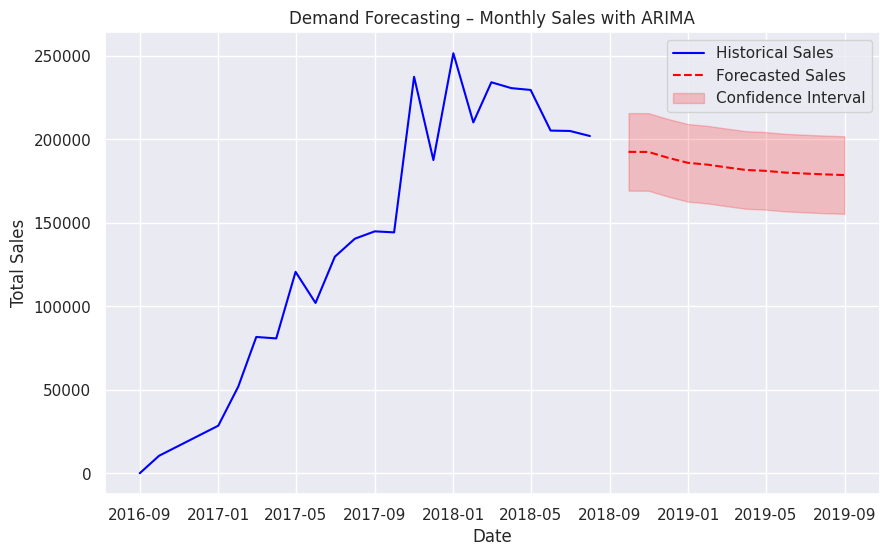

In [19]:
# Visualize historical + forecast
plt.figure(figsize=(10, 6))
plt.plot(sales_ts, label='Historical Sales', color='blue')
plt.plot(forecast_index, forecast, label='Forecasted Sales', color='red', linestyle='--')
plt.fill_between(forecast_index, forecast - model_fit.resid.std(), forecast + model_fit.resid.std(), color='red', alpha=0.2, label='Confidence Interval')
plt.title('Demand Forecasting – Monthly Sales with ARIMA')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.legend()
plt.show()

In [22]:
# Interpret
print("Forecasted Sales for Next 12 Months:")
forecast
# Insights: If forecast shows dip, stock less; rise = ramp up procurement. Check AIC in summary for model fit.

Forecasted Sales for Next 12 Months:


,predicted_mean
22,192574.613329
23,192527.443927
24,189077.317137
25,186024.667079
26,184906.094527
27,183366.349618
28,181751.060183
29,181233.110432
30,180179.161532
31,179616.113178


<font size=6 color=skyblue >4. Cross-Sell Recommendations (Association Rule Mining)

---

**Goal**: Find product bundles (e.g., "Buy A, get B") to boost order value.
> <font color=orange>Why? Unsupervised rules reveal "if-then" patterns (e.g., accessories with phones).

**Method**: Apriori algorithm for frequent itemsets.

**Sequence**: Prep basket data → Find rules → Visualize → Interpret.

In [23]:
# Prep basket data – Transactions as binary (1 if product in order, 0 else)
basket = sales.groupby(['order_id', 'product_id'])['product_id'].count().unstack().fillna(0)
basket = basket.applymap(lambda x: 1 if x > 0 else 0)  # Binary encoding
print("Basket Shape:", basket.shape)  # Rows=orders, Columns=products

Basket Shape: (24421, 13148)


In [26]:
# Find frequent itemsets with Apriori
min_support = 0.01  # 1% of orders – adjust for data size
frequent_itemsets = apriori(basket, min_support=min_support, use_colnames=True)
print("Frequent Itemsets (Top 10):")
frequent_itemsets.head(10)

Frequent Itemsets (Top 10):


,support,itemsets


In [27]:
import pandas as pd
from mlxtend.frequent_patterns import apriori, association_rules

# Adjust min_support to a lower value to find more frequent itemsets
# Original min_support = 0.01 was too high, resulting in an empty frequent_itemsets DataFrame.
new_min_support = 0.0005  # This means an itemset must appear in at least 0.05% of orders
frequent_itemsets = apriori(basket, min_support=new_min_support, use_colnames=True)

print("Frequent Itemsets (Top 10):")
print(frequent_itemsets.head(10))

# Generate association rules
if not frequent_itemsets.empty:
    rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1.0)  # Lift >1 means strong association
    rules = rules.sort_values('lift', ascending=False)
    print("\nTop Association Rules:")
    print(rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']].head(10))
else:
    print("\nNo frequent itemsets found even with the adjusted min_support. Consider further reducing min_support if needed.")
    rules = pd.DataFrame() # Create an empty DataFrame for 'rules' to prevent errors in subsequent cells

Frequent Itemsets (Top 10):
    support                            itemsets
0  0.000614  (0152f69b6cf919bcdaf117aa8c43e5a2)
1  0.001269  (06edb72f1e0c64b14c5b79353f7abea3)
2  0.001228  (08574b074924071f4e201e151b152b4e)
3  0.000983  (0a57f7d2c983bcf8188589a5fea4a8da)
4  0.001597  (0aabfb375647d9738ad0f7b4ea3653b1)
5  0.000737  (0bcc3eeca39e1064258aa1e932269894)
6  0.000532  (11875b30b49585209e608f40e8082e65)
7  0.002866  (154e7e31ebfa092203795c972e5804a6)
8  0.000737  (1613b819ab5dae53aead2dbb4ebdb378)
9  0.000942  (165f86fe8b799a708a20ee4ba125c289)

Top Association Rules:
Empty DataFrame
Columns: [antecedents, consequents, support, confidence, lift]
Index: []


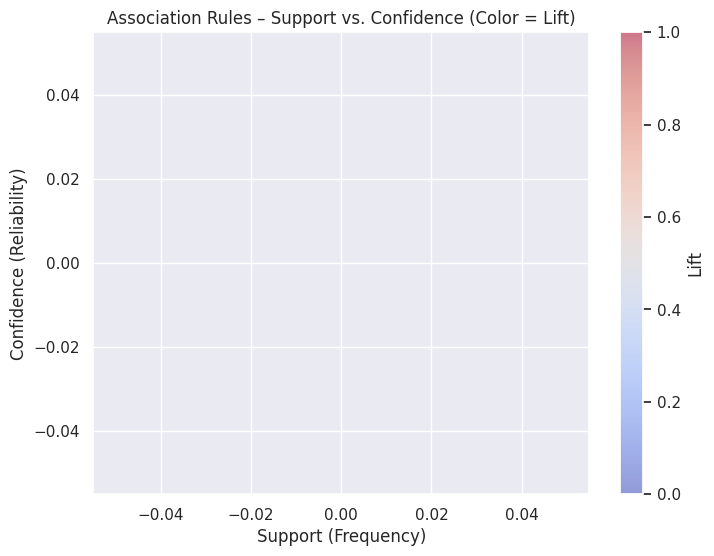

In [28]:
# Visualize rules (scatter plot of support vs. confidence)
plt.figure(figsize=(8, 6))
plt.scatter(rules['support'], rules['confidence'], alpha=0.5, c=rules['lift'], cmap='coolwarm')
plt.colorbar(label='Lift')
plt.title('Association Rules – Support vs. Confidence (Color = Lift)')
plt.xlabel('Support (Frequency)')
plt.ylabel('Confidence (Reliability)')
plt.show()

In [30]:
# Interpret
# Insights: High lift rules (e.g., Lift>2) are strong bundles. E.g., "If buy product X, likely buy Y" for cross-sell.
# Business: Bundle recommendations in cart (e.g., "Customers who bought phone also bought case").